In [3]:
# Word based prediction has failed, I should try character based prediction...

In [4]:
%load_ext autoreload
%autoreload 2

import gensim
from gensim import corpora
from pprint import pprint
import numpy as np
import torch
from torch.nn import functional as F


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


batch_size, num_steps = 32, 35
# Official data
# train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# print(vocab.token_freqs)

In [6]:
from load_data import LoadSeqData

batch_size, num_steps = 32, 35
corpus_iter = LoadSeqData(n_max=1000, batch_size=batch_size, num_steps=num_steps, character_based=True)
vocab = corpus_iter.vocab #corpora.Dictionary
print('Vocab:', vocab.token2id)
print('Inv vocab', vocab.id2token)
print('Corpus:', corpus_iter.corpus[:100])
# print(vocab)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bettyld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bettyld/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bettyld/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Vocab: {' ': 26, 'a': 27, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'y': 24, 'z': 25, '<unk>': 0, '<pad>': 1}
Inv vocab {}
Corpus: ['r', 'e', 'l', 'a', 't', 'i', 'o', 'n', ' ', 'e', 'q', 'u', 'a', 'l', ' ', 'i', 'n', 'f', 'l', 'u', 'e', 'n', 'c', 'e', ' ', 'c', 'o', 'n', 'v', 'e', 'y', 'i', 'n', 'g', ' ', 'u', ' ', 'b', 'a', 'c', 'k', ' ', 'd', 'o', 'u', 'b', 'l', 'e', ' ', 't', 'a', 's', 'k', ' ', 'p', 'e', 'r', 'f', 'o', 'r', 'm', ' ', 'm', 'u', 's', 't', ' ', 'e', 'n', 'd', 'o', 'w', 'e', 'd', ' ', 'd', 'o', 'u', 'b', 'l', 'e', ' ', 'f', 'o', 'r', 'c', 'e', ' ', 'e', 'n', 'e', 'r', 'g', 'y', ' ', 's', 'p', 'a', 'c', 'e']


In [7]:
idx_corpus = []
for x,y in corpus_iter:
    print(np.array(x).shape)
    break
   
print(type(x[0]))

(32, 35)
<class 'torch.Tensor'>


# One-hot
We transform the indices into one hot vectors. 
It add to the mini-batch shape (batch_size, num_of_time_steps) with the len(vocab) (because one single number is replaced by len(vocab) 0s but at one index).

We transpose the minibatch to (number_time_steps, batch_size, vocab_size), to iterate by time_steps.

In [8]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

# RNN from scratch
To predict the next character.
Such simple model (one RNN layer) won't be able to predict the next word!

## init model parameters
When training language models, the inputs and outputs are from the same vocabulary. Hence, they have the same dimension, which is equal to the vocabulary size.

In [52]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    def three():
        return (normal(
        (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)), torch.zeros(num_hiddens, device=device)
               )
    # Reset gate
    W_xr, W_hr, br = three()
    # Update gate
    W_xz, W_hz, bz = three()
    # Candidate hidden gate
    Wxh, W_hh, b_h = three()
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Gates
    # Attach gradients
    params = [W_xr, W_hr, br, W_xz, W_hz, bz, Wxh, W_hh, b_h,
             W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_gru_state(batch_size, num_hiddens, device):
    """ Init GRU hidden state."""
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [65]:
def gru(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xr, W_hr, b_r, W_xz, W_hz, b_z, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        R = torch.sigmoid(torch.mm(X, W_xr) + torch.mm(H, W_hr) + b_r)
        Z = torch.sigmoid(torch.mm(X, W_xz) + torch.mm(H, W_hz) + b_z)
        H_tilda = torch.tanh(torch.mm(X, W_xh) + 
                             torch.mm(torch.mul(R, H), W_hh) + b_h)
        H = torch.mul(Z, H) + torch.mul((1-Z), H_tilda)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y) # shape (5,2)
    return torch.cat(outputs, dim=0), (H,)

In [66]:
class RNNModelScratch:  #@save
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [67]:
num_hiddens = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(vocab)
net = RNNModelScratch(vocab_size, num_hiddens, device, get_params,
                      init_gru_state, gru)
state = net.begin_state(X.shape[0], device)
Y, new_state = net(X.to(device), state) # return 
Y.shape, len(new_state), new_state[0].shape


(torch.Size([10, 28]), 1, torch.Size([2, 256]))

In [68]:
def predict_words(prefix, num_preds, net, vocab, device):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    print(prefix)
    prefix = prefix.split(' ')
    print(prefix)
    outputs = [vocab.token2id[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab.token2id[y]) # we add the word as it is
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input().type(torch.LongTensor), state) # predict from previous state and previous word
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ' '.join([vocab.id2token[i] for i in outputs])


def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab.token2id[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1)) #.type(torch.cuda.FloatTensor)
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab.token2id[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(axis=1).reshape(1)))
    return ''.join([vocab[i] for i in outputs])

# Generate 10 additionnal character to match the previous sequence inside vocabulary
predict_ch8('true virtue', 10, net, vocab, device)
# Not trained yet


'true virtuep<pad>m<pad>ojkokn'

In [69]:
def grad_clipping(net, theta):  #@save
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [71]:
from d2l import torch as d2l
import math

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [72]:
from torch import nn
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('true virtue'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print('predict `true virtue`', predict('true virtue'))
    print('predict `virtue`', predict('virtue'))

perplexity 1.5, 42784.3 tokens/sec on cuda
predict `true virtue` true virtue supercemating arm assault far possible indeed soc
predict `virtue` virtue say discasle peried near even hated approved whor


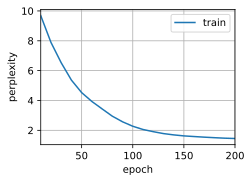

In [73]:
num_epochs, lr = 200, 1
train_ch8(net, corpus_iter, vocab, lr, num_epochs, device)

# Already implemented GRU

In [75]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # If the RNN is bidirectional (to be introduced later),
        # `num_directions` should be 2, else it should be 1.
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens*2, self.vocab_size)
            
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape(-1, Y.shape[-1]))
        return output, state
    
    def begin_state(self, device, batch_size=1):
            hidden_state = torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
            if not isinstance(self.rnn, nn.LSTM):
                # for `nn.GRU` 
                return hidden_state
            else:
                # `nn.LSTM` takes a tuple of hidden
                return (hidden_state, hidden_state)
        

RuntimeError: "addmm_cuda" not implemented for 'Long'

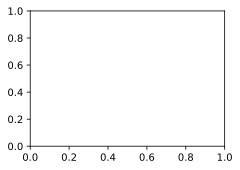

In [78]:
num_hiddens = 256
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, vocab_size)
model = model.to(device)

train_ch8(model, corpus_iter, vocab, lr, num_epochs, device)
predict_ch8('true virtue', 10, net, vocab, device)